<a href="https://colab.research.google.com/github/pritam5756/Predict-spike-counts-with-Linear-Gaussian-model/blob/main/LGRM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict** spike counts with Linear-Gaussian **model**

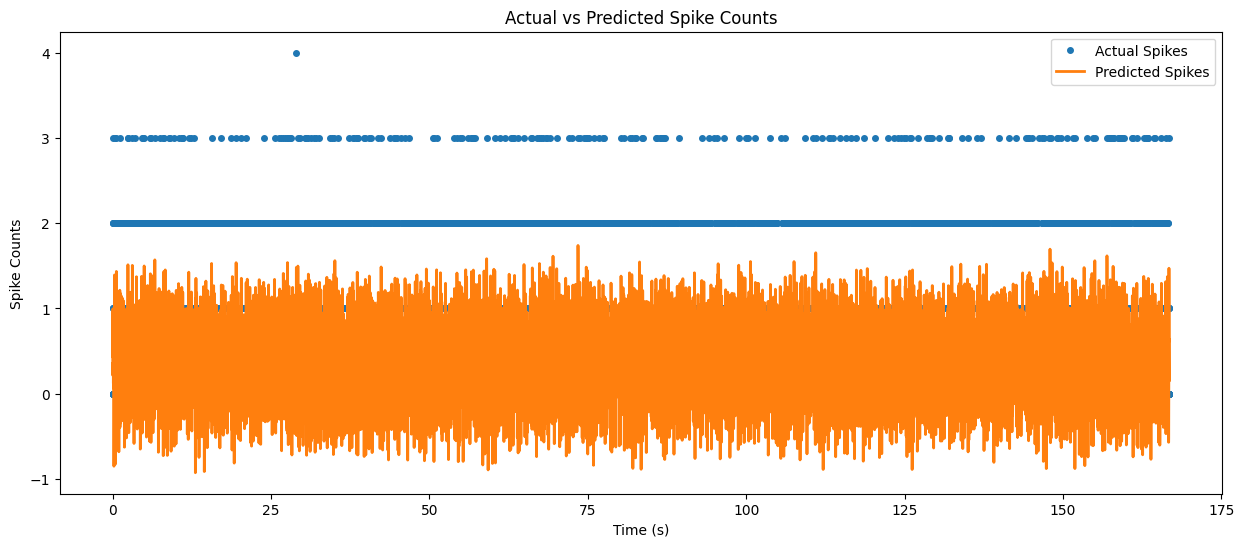

In [9]:
import os
import hashlib
import requests
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Constants
FNAME = "RGCdata.mat"
URL = "https://osf.io/mzujs/download"
EXPECTED_MD5 = "1b2977453020bce5319f2608c94d38d0"
CELLNUM = 2
KEEP_TIMEPOINTS = 20000

def download_data(fname, url, expected_md5):
    """Download the data file if not already present."""
    if not os.path.isfile(fname):
        try:
            response = requests.get(url)
            response.raise_for_status()
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return False
        else:
            if hashlib.md5(response.content).hexdigest() != expected_md5:
                print("!!! Data download appears corrupted !!!")
                return False
            with open(fname, "wb") as fid:
                fid.write(response.content)
    return True

def make_design_matrix(stim, d=25):
    """Create time-lag design matrix from stimulus intensity vector."""
    padded_stim = np.concatenate([np.zeros(d - 1), stim])
    T = len(stim)
    X = np.zeros((T, d))
    for t in range(T):
        X[t] = padded_stim[t:t + d]
    return X

def predict_spike_counts_lg(stim, spikes, d=25):
    """Compute a vector of predicted spike counts given the stimulus."""
    y = spikes
    constant = np.ones_like(y)
    X = np.column_stack([constant, make_design_matrix(stim)])
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    yhat = X @ theta
    return yhat

def plot_spikes_with_prediction(spikes, predicted_counts, dt_stim):
    """Plot actual vs predicted spike counts."""
    time = np.arange(len(spikes)) * dt_stim
    plt.figure(figsize=(15, 6))
    plt.plot(time, spikes, label='Actual Spikes', marker='o', linestyle='None', markersize=4)
    plt.plot(time, predicted_counts, label='Predicted Spikes', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Counts')
    plt.title('Actual vs Predicted Spike Counts')
    plt.legend()
    plt.show()

def main():
    # Download data
    if not download_data(FNAME, URL, EXPECTED_MD5):
        return

    # Load data
    data = loadmat(FNAME)
    dt_stim = data['dtStim'].item()
    stim = data['Stim'].squeeze()
    spikes = data['SpCounts'][:, CELLNUM]

    # Trim data to keep desired timepoints
    stim = stim[:KEEP_TIMEPOINTS]
    spikes = spikes[:KEEP_TIMEPOINTS]

    # Predict spike counts
    predicted_counts = predict_spike_counts_lg(stim, spikes)

    # Visualize
    plot_spikes_with_prediction(spikes, predicted_counts, dt_stim)

if __name__ == "__main__":
    main()
